In [1]:
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gym_tetris.actions import SIMPLE_MOVEMENT

In [2]:
def calc_iqm(data):
    sorted_data = np.sort(data)

    q1 = np.percentile(sorted_data, 25)
    q3 = np.percentile(sorted_data, 75)

    interquartile_range = sorted_data[(sorted_data >= q1) & (sorted_data <= q3)]

    return interquartile_range.mean()

In [3]:
def confidence_intervals(population,  parameter, n_sample = 100, iterasi=5000, alpha=0.05, stratified=False, aggregate = "iqm"):
    stats = np.array([])

    for _ in range(iterasi):
        if not stratified:
            sample = population[parameter].sample(n_sample, replace=True)
        else:
            sample = population.groupby('level', group_keys=False).apply(lambda x: x[parameter].sample(n=200, replace=True), include_groups=False).reset_index(drop=True)
        if aggregate == "iqm":
            stat = calc_iqm(sample)
        elif aggregate == "mean":
            stat = np.mean(sample)
        elif aggregate == "median":
            stat = np.median(sample)
        stats = np.append(stats, stat)

    lower_bound = np.percentile(stats, 100 * alpha / 2)
    upper_bound = np.percentile(stats, 100 * (1 - alpha / 2))
    
    return stats, lower_bound, upper_bound, np.mean(stats), np.std(stats)

In [4]:
def plot_interval(df: pd.DataFrame, title: str, metrics: list = [], levels: list = []):
    fig, axes = plt.subplots(1, len(metrics), figsize=(6 * len(metrics), max(len(levels) * .5, 4)))
    axes = [axes] if len(metrics) == 1 else axes.flatten()

    color_palette = sns.color_palette('colorblind', n_colors=len(levels))
    colors = dict(zip(levels, color_palette))

    for m_idx, metric_name in enumerate(metrics): # IQM, mean, median dari suatu parameter
        ax = axes[m_idx]
        sub_df = df[df["parameter"] == metric_name]
        x_min, x_max = sub_df["lower_bound"].min(), sub_df["upper_bound"].max()
        ci_range = x_max - x_min
        padding = ci_range * .2
        ax.set_xlim(x_min - padding, x_max + padding)

        for idx, level in enumerate(levels): # biasanya level
            level_data = sub_df[sub_df["level"] == level]
            lower = level_data["lower_bound"].values[0]
            upper = level_data["upper_bound"].values[0]
            mean = level_data["mean"].values[0]
            
            # Plotkan interval kepercayaan untuk metrik (bar horizontal)
            ax.barh(y=idx, width=upper - lower, left=lower, height=0.7, alpha=0.75, color=colors[level], label=f'{metric_name} Interval' if idx == 0 else "")
            # Plotkan nilai rata-rata untuk metrik (garis vertikal)
            ax.vlines(x=mean, ymin=idx - 0.3, ymax=idx + 0.3, color='k', alpha=0.7)

        ax.set_yticks(list(range(len(levels))))
        ax.set_xticks(np.linspace(x_min, x_max, 100))
        ax.xaxis.set_major_locator(plt.MaxNLocator(8))
        # Set label untuk subplot
        if m_idx % 2 == 0:
            ax.set_yticklabels(levels, fontsize="medium")
            ax.set_ylabel("Level")
        else:
            ax.set_yticklabels([])

        ax.set_xlabel(f"{metric_name.replace('_', ' ').capitalize()} (IQM)")
        # ax.set_title(f"{metric_name.replace('_', ' ').capitalize()} {title}", fontsize='x-large')
        
        ax.tick_params(axis='both', which='major', length=0 if m_idx != 0 else 5)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(True, axis='x', alpha=0.25)
        
    for j in range(len(metrics), len(axes)):
        fig.delaxes(axes[j])  # Menghapus subplot yang tidak digunakan

    # Coba gunakan tight_layout() untuk penyesuaian otomatis layout
    fig.text(0.46, 1, f"{title}", ha='center', fontsize='xx-large')
    # fig.suptitle(f"{title}", fontsize='xx-large')
    # plt.tight_layout(w_pad=3)  # Mengatur jarak antar subplot dengan padding
    plt.subplots_adjust(wspace=0.12, hspace=0.05, left=0.0)

    return fig, axes

In [5]:
def validate_95_percent_ci(data, lower_bound, upper_bound):
    count_in_range = np.sum((data >= lower_bound) & (data <= upper_bound))
    proportion_in_range = count_in_range / len(data)
    return proportion_in_range

In [6]:
def parse_board_heatmap(string_array):
    clean_str = string_array.replace('array(', '').replace(', dtype=uint8)', '').replace('\n', '')
    return np.array(ast.literal_eval(clean_str))

In [11]:
data = []
action_data = []
for i in range(11):
    if i == 0:
        df = pd.read_csv(f"./UNREAL-eval/CI/csv/10-slow.csv")
    else:
        df = pd.read_csv(f"./UNREAL-eval/CI/csv/{i}.csv")
    df["level"] = 9 + i
    df["lines_history"] = df["lines_history"].apply(lambda x: ast.literal_eval(x))
    df["board_history"] = df["board_history"].apply(parse_board_heatmap).apply(lambda x: np.sum(x, axis=0))
    
    action_freq = np.array([
        [seq.count(str(action)) for action in range(6)] for seq in df["action_taken"]
    ])
    total_action_freq = action_freq.sum(axis=0)

    action_freq_df = pd.DataFrame([total_action_freq], columns=[' '.join(item) for item in SIMPLE_MOVEMENT])
    action_freq_df["level"] = i + 10

    data.append(df)
    action_data.append(action_freq_df)

data = pd.concat(data, ignore_index=True)
action_data = pd.concat(action_data, ignore_index=True)

In [12]:
LINE_REWARDS = {1: 40, 2: 100, 3: 300, 4: 1200}

In [13]:
data["scaled_rewards"] = data.apply(
    lambda row: row["score"] + row["block_placed"] * 0.5 - row["level"] * sum(
        [LINE_REWARDS[line] for line in row["lines_history"]]
    ), axis=1
)
data["softdrop_rewards"] = data.apply(
    lambda row: row["score"] - (row["level"] + 1) * sum(
        [LINE_REWARDS[line] for line in row["lines_history"]]
    ), axis=1
)

In [14]:
max_r = data["scaled_rewards"].max()
min_r = data["scaled_rewards"].min()
data["normalized_rewards"] = data["scaled_rewards"].apply(
    lambda row: (row - min_r) / (max_r- min_r)
)

In [17]:
data.head()

,lines,score,rewards,block_placed,episode_time,episode_length,action_taken,lines_history,board_history,level,scaled_rewards,softdrop_rewards,normalized_rewards
0,0,0,-235.41,32,38.333931,2567,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[],"[[0, 0, 9, 0, 1, 1, 1, 2, 2, 0], [0, 0, 9, 0, ...",9,16.0,0,0.096070
1,0,0,-231.93,28,34.883907,2173,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",[],"[[9, 9, 0, 0, 1, 1, 2, 0, 0, 0], [10, 9, 0, 0,...",9,14.0,0,0.078603
2,0,2,-223.11,28,36.724746,2359,"[1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",[],"[[0, 0, 0, 0, 0, 0, 3, 3, 0, 0], [7, 0, 0, 0, ...",9,16.0,2,0.096070
3,0,0,-218.70,28,38.298395,2359,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",[],"[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, ...",9,14.0,0,0.078603
4,0,0,-233.34,31,39.805633,2457,"[1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",[],"[[0, 0, 0, 0, 0, 1, 3, 3, 0, 0], [0, 7, 0, 0, ...",9,15.5,0,0.091703


In [18]:
cumsum_data = data.groupby('level')[["block_placed", "lines", "scaled_rewards", "softdrop_rewards"]].cumsum()
cumsum_data.columns = ["cumsum_blocks", "cumsum_lines", "cumsum_scaled_rewards", "cumsum_softdrop_rewards"]
cumsum_data["level"] = data["level"]

In [19]:
cumsum_data.groupby('level')["cumsum_lines"].max()

level
9      2
10     0
11     0
12     3
13     1
14     3
15     1
16     1
17     1
18     0
19    11
Name: cumsum_lines, dtype: int64

In [20]:
action_data = action_data.set_index("level")
action_data.head()

,NOOP,A,B,right,left,down
level,,,,,,
10,2655,3466,4864,11634,12242,444
11,3959,4266,1152,466,1534,2130
12,1729,4505,3552,4596,7956,402
13,5760,4072,833,1848,3428,2762
14,3094,3175,1423,1425,3518,1672


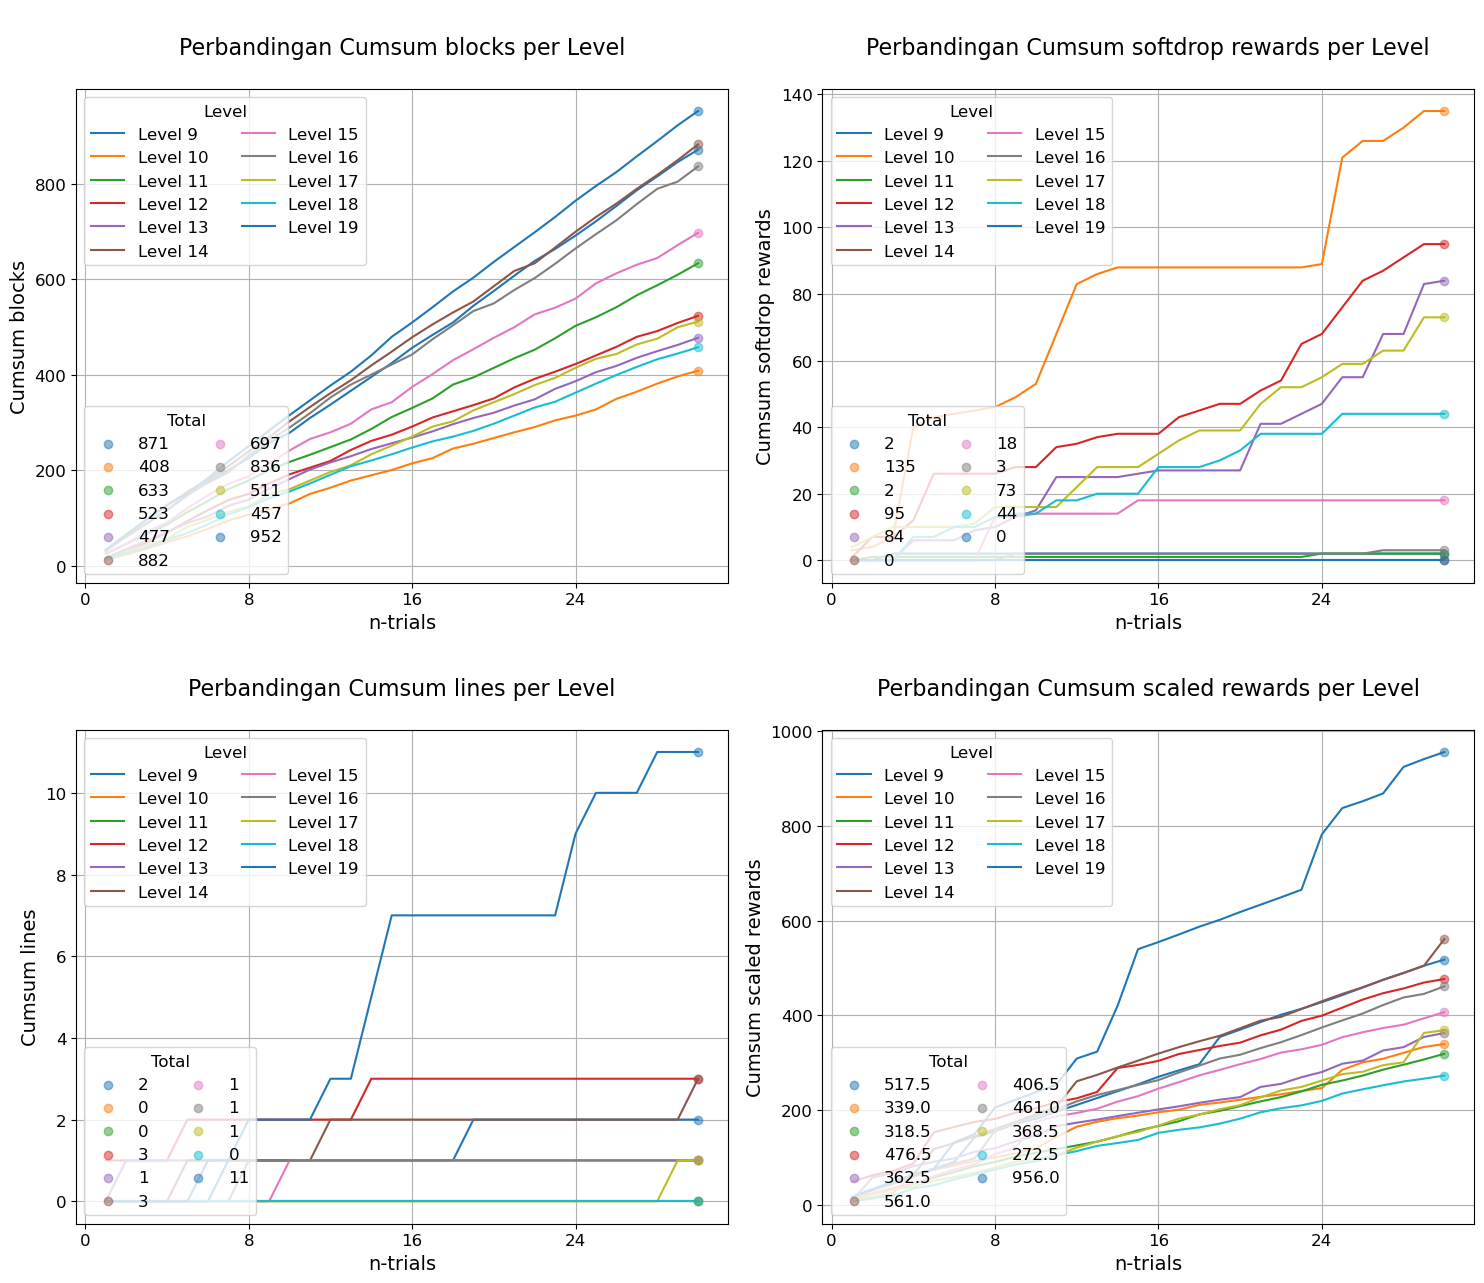

In [23]:
plt.rcParams.update({
    'font.size': 12,          # Ukuran font default
    'axes.titlesize': 16,     # Ukuran font judul plot
    'axes.labelsize': 14,     # Ukuran font label sumbu
    'xtick.labelsize': 12,    # Ukuran font tick label sumbu x
    'ytick.labelsize': 12,    # Ukuran font tick label sumbu y
    'legend.fontsize': 12,    # Ukuran font legend
})
metrics = ['cumsum_blocks',  'cumsum_softdrop_rewards', 'cumsum_lines', 'cumsum_scaled_rewards',]

# Membuat subplot untuk setiap metrik
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 13))
axes = axes.flatten()  # Mengubah axes menjadi array 1D untuk memudahkan iterasi

# Plotting untuk setiap metrik
for i, metric in enumerate(metrics):
    lines = []  # Untuk menyimpan objek line
    dots = []   # Untuk menyimpan objek dot
    for level in range(11):
        level_data = cumsum_data[cumsum_data['level'] == level + 9]
        line, = axes[i].plot(range(1, len(level_data) + 1), level_data[metric], label=f"Level {level + 9}")
        lines.append(line)
        max_value = level_data[metric].max()  # Ambil nilai maksimum
        dot = axes[i].scatter(30, max_value, zorder=10, label=f'{max_value}', alpha=0.5) # Plot titik tertinggi
        dots.append(dot)

    metric = metric.replace("_", " ").capitalize()
    axes[i].set_title(f'\nPerbandingan {metric} per Level\n')
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel('n-trials')
    legend1 = axes[i].legend(handles=lines, loc='upper left', title='Level', ncol=2)
    axes[i].add_artist(legend1)  # Menambahkan legend pertama ke axes

    # Membuat legend kedua (Max Value)
    legend2 = axes[i].legend(handles=dots, loc='lower left', title='Total', ncol=2)
    axes[i].grid(True)  # Menambahkan grid untuk memudahkan pembacaan
    axes[i].set_xticks([1] + list(range(5, 31, 5)))

    axes[i].xaxis.set_major_locator(plt.MaxNLocator(5))
plt.tight_layout()  # Agar subplot tidak tumpang tindih
plt.show()

In [24]:
cumsum_data.groupby('level')["cumsum_scaled_rewards"].max()

level
9     517.5
10    339.0
11    318.5
12    476.5
13    362.5
14    561.0
15    406.5
16    461.0
17    368.5
18    272.5
19    956.0
Name: cumsum_scaled_rewards, dtype: float64

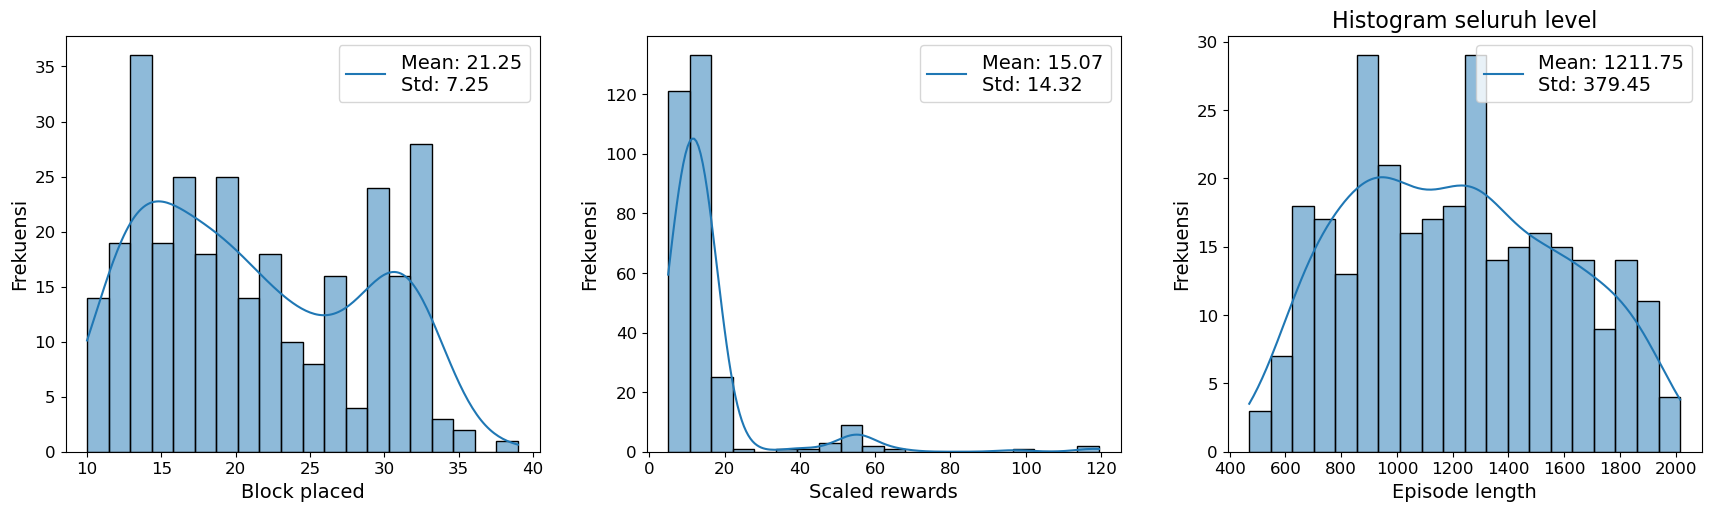

In [61]:
plt.rcParams.update({
    'font.size': 13,          # Ukuran font default
    'axes.titlesize': 16,     # Ukuran font judul plot
    'axes.labelsize': 14,     # Ukuran font label sumbu
    'xtick.labelsize': 12,    # Ukuran font tick label sumbu x
    'ytick.labelsize': 12,    # Ukuran font tick label sumbu y
    'legend.fontsize': 14,    # Ukuran font legend
})

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 baris, 2 kolom
for i, parameter in enumerate(["block_placed", "scaled_rewards", "episode_length"]):
    # Membuat histogram distribusi data
    mean = data[data["level"] != 9][parameter].mean()
    std = data[data["level"] != 9][parameter].std()
    sns.histplot(data[data["level"] != 9][parameter], bins=20, kde=True, stat="count", ax=axes[i])
    label = f'Mean: {mean:.2f}\nStd: {std:.2f}'

    # Menambahkan keterangan (legend)
    axes[i].legend([label], loc='upper right', fontsize=14)

    # Melabeli judul, sumbu-X, dan sumbu-Y
    axes[i].set_xlabel(f'{parameter.replace("_", " ").capitalize()}')
    axes[i].set_ylabel('Frekuensi')

plt.title('Histogram seluruh level')
plt.tight_layout(pad=3.0, h_pad=2.0, w_pad=2.0)
plt.show()

In [62]:
generalized_data = []
for i, parameter in enumerate(["block_placed", "scaled_rewards", "episode_length"]):
    stats, lb, ub, mean, std = confidence_intervals(data[data["level"] != 9], parameter, stratified=True, aggregate="iqm")
    generalized_data.append([stats, lb, ub, mean, std, parameter])

generalized_df = pd.DataFrame(generalized_data, columns=["stat", "lower_bound", "upper_bound", "mean", "std", "parameter"]).drop(columns=["stat"])
generalized_df["level"] = "10 - 19"
generalized_df.head()

,lower_bound,upper_bound,mean,std,parameter,level
0,20.082363,20.952130,20.432380,0.253820,block_placed,10 - 19
1,11.843399,12.557163,12.218104,0.213341,scaled_rewards,10 - 19
2,1177.350124,1204.018225,1191.133207,6.757654,episode_length,10 - 19


(<Figure size 1800x400 with 3 Axes>,
 array([<Axes: xlabel='Block placed (IQM)', ylabel='Level'>,
        <Axes: xlabel='Scaled rewards (IQM)'>,
        <Axes: xlabel='Episode length (IQM)', ylabel='Level'>],
       dtype=object))

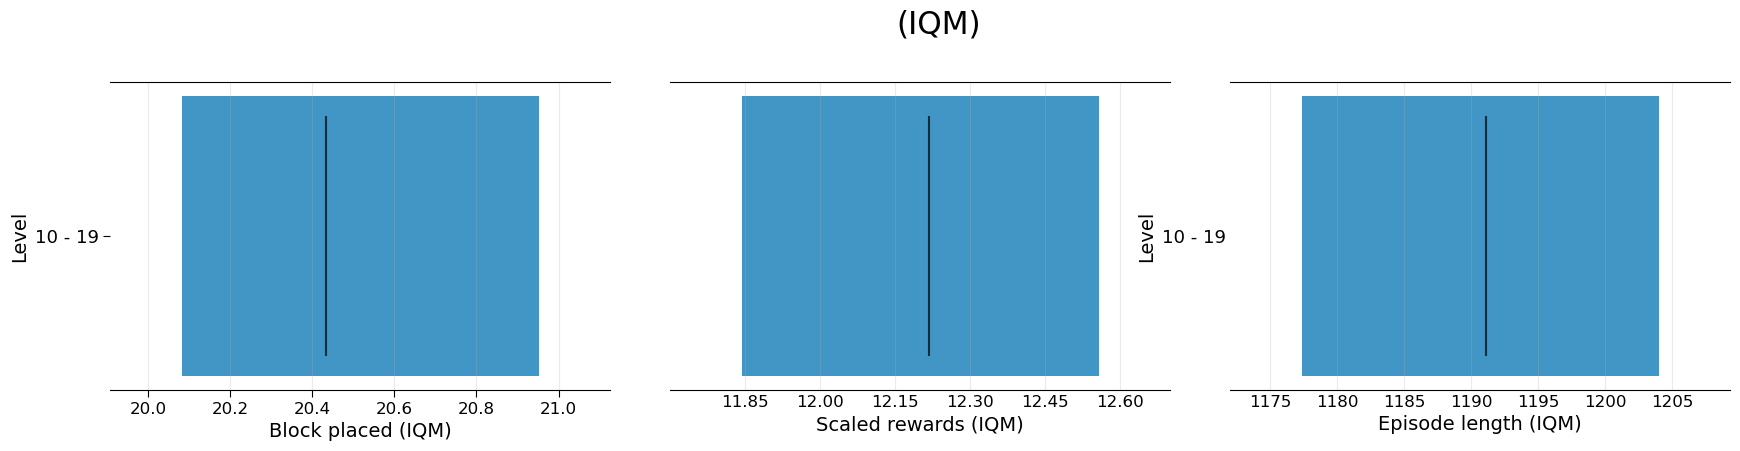

In [63]:
plot_interval(generalized_df, "(IQM)", generalized_df.parameter.unique(), generalized_df.level.unique())

Percentage: 95.0%
Percentage: 95.0%
Percentage: 95.0%


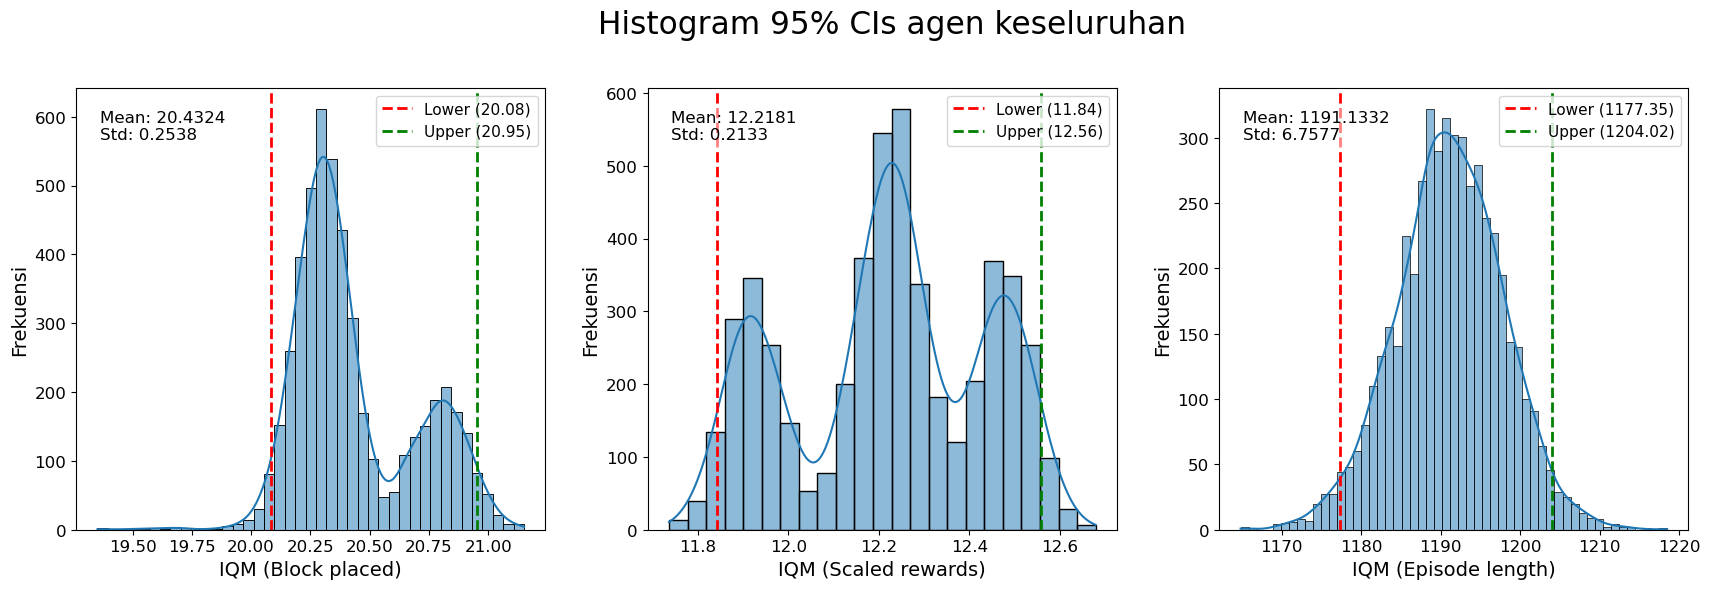

In [ ]:
plt.rcParams.update({
    'font.size': 13,          # Ukuran font default
    'axes.titlesize': 16,     # Ukuran font judul plot
    'axes.labelsize': 14,     # Ukuran font label sumbu
    'xtick.labelsize': 12,    # Ukuran font tick label sumbu x
    'ytick.labelsize': 12,    # Ukuran font tick label sumbu y
    'legend.fontsize': 12,    # Ukuran font legend
})

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 baris, 2 kolom
axes = axes.flatten()
for i, parameter in enumerate(["block_placed", "scaled_rewards", "episode_length"]):
    stats, lb, ub, mean, std, _ = generalized_data[i]

    # Membuat histogram distribusi data
    sns.histplot(stats, ax=axes[i], kde=True, stat="count")

    # Membuat garis lower dan upper bound
    axes[i].axvline(lb, color='r', linestyle='dashed', linewidth=2, label=f'Lower ({lb:.2f})')
    axes[i].axvline(ub, color='g', linestyle='dashed', linewidth=2, label=f'Upper ({ub:.2f})')

    axes[i].text(0.05, 0.95, f'Mean: {mean:.4f}\nStd: {std:.4f}', transform=axes[i].transAxes,
            fontsize=12, va='top', ha='left', bbox=dict(boxstyle="round", alpha=0.5, color="white"))

    # Menambahkan keterangan (legend)
    axes[i].legend(loc='upper right', fontsize=11)

    # Melabeli judul, sumbu-X, dan sumbu-Y
    axes[i].set_xlabel(f'IQM ({parameter.replace("_", " ").capitalize()})')
    axes[i].set_ylabel('Frekuensi')

    is_valid = validate_95_percent_ci(stats, lb, ub)
    print(f"Percentage: {is_valid * 100}%")

# plt.tight_layout()  # Mengatur layout agar tidak overlap
fig.text(0.52, 1, f"Histogram 95% CIs IQM agen keseluruhan", ha='center', fontsize='xx-large')
plt.tight_layout(pad=3.0, w_pad=2.0)
plt.show()

In [65]:
level_data = []
for i, parameter in enumerate(["block_placed", "scaled_rewards", "episode_length"]):
    for i in range(11):
        data_level = data[data["level"] == i+9]
        stats, lb, ub, mean, std = confidence_intervals(data_level, parameter, aggregate="iqm")
        level_data.append([stats, lb, ub, mean, std, i + 9, parameter])

level_df = pd.DataFrame(
    level_data,
    columns=["stat", "lower_bound", "upper_bound", "mean", "std", "level", "parameter"],
).drop(columns=['stat'])
level_df.head()

,lower_bound,upper_bound,mean,std,level,parameter
0,28.596094,30.270299,29.455862,0.458764,9,block_placed
1,12.041082,13.490909,12.727628,0.421541,10,block_placed
2,20.105263,22.366774,21.135039,0.557691,11,block_placed
3,16.086170,18.313799,17.076816,0.597687,12,block_placed
4,14.188406,16.213357,14.959200,0.529302,13,block_placed


(<Figure size 1800x550 with 3 Axes>,
 array([<Axes: xlabel='Block placed (IQM)', ylabel='Level'>,
        <Axes: xlabel='Scaled rewards (IQM)'>,
        <Axes: xlabel='Episode length (IQM)', ylabel='Level'>],
       dtype=object))

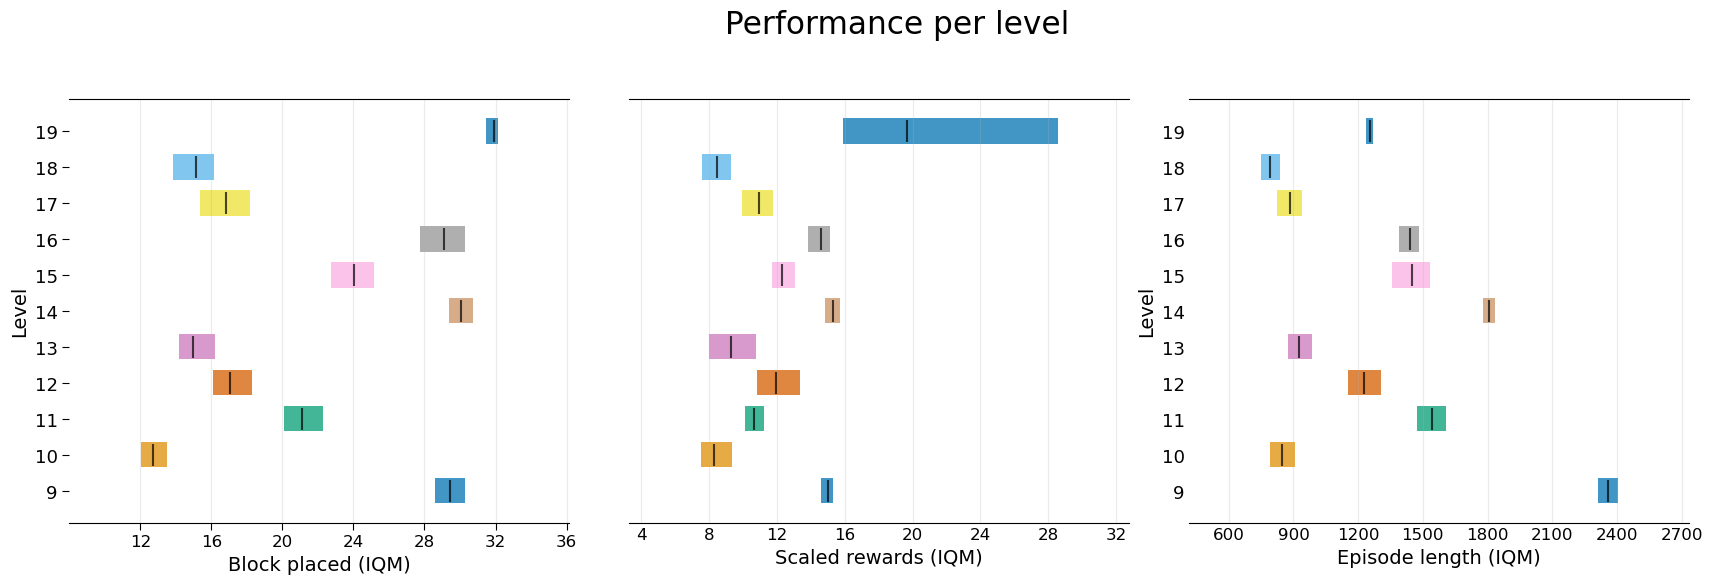

In [32]:
plot_interval(level_df, "Performance per level", level_df.parameter.unique(), level_df.level.unique())

In [ ]:
level_data = []
for i, parameter in enumerate(["block_placed", "scaled_rewards", "episode_length"]):
    for i in range(11):
        data_level = data[data["level"] == i+9]
        stats, lb, ub, mean, std = confidence_intervals(data_level, parameter, aggregate="mean")
        level_data.append([stats, lb, ub, mean, std, i + 9, parameter])

level_df_mean = pd.DataFrame(
    level_data,
    columns=["stat", "lower_bound", "upper_bound", "mean", "std", "level", "parameter"],
).drop(columns=['stat'])
level_df_mean.head()

In [ ]:
plot_interval(level_df_mean, "Performance per level", level_df_mean.parameter.unique(), level_df.level.unique())

In [ ]:
level_data = []
for i, parameter in enumerate(["block_placed", "scaled_rewards", "episode_length", "softdrop_rewards"]):
    for i in range(11):
        data_level = data[data["level"] == i+9]
        stats, lb, ub, mean, std = confidence_intervals(data_level, parameter, aggregate="iqm")
        level_data.append([stats, lb, ub, mean, std, i + 9, parameter])

level_df_2nd = pd.DataFrame(
    level_data,
    columns=["stat", "lower_bound", "upper_bound", "mean", "std", "level", "parameter"],
).drop(columns=['stat'])
level_df_2nd.head()

,lower_bound,upper_bound,mean,std,level,parameter
0,28.582090,30.281690,29.453100,0.461796,9,block_placed
1,12.027018,13.500000,12.722339,0.423531,10,block_placed
2,20.125000,22.328358,21.139176,0.557747,11,block_placed
3,16.052587,18.294221,17.069572,0.606850,12,block_placed
4,14.203125,16.193028,14.946915,0.511522,13,block_placed


(<Figure size 2400x550 with 4 Axes>,
 array([<Axes: xlabel='Block placed (IQM)', ylabel='Level'>,
        <Axes: xlabel='Scaled rewards (IQM)'>,
        <Axes: xlabel='Episode length (IQM)', ylabel='Level'>,
        <Axes: xlabel='Softdrop rewards (IQM)'>], dtype=object))

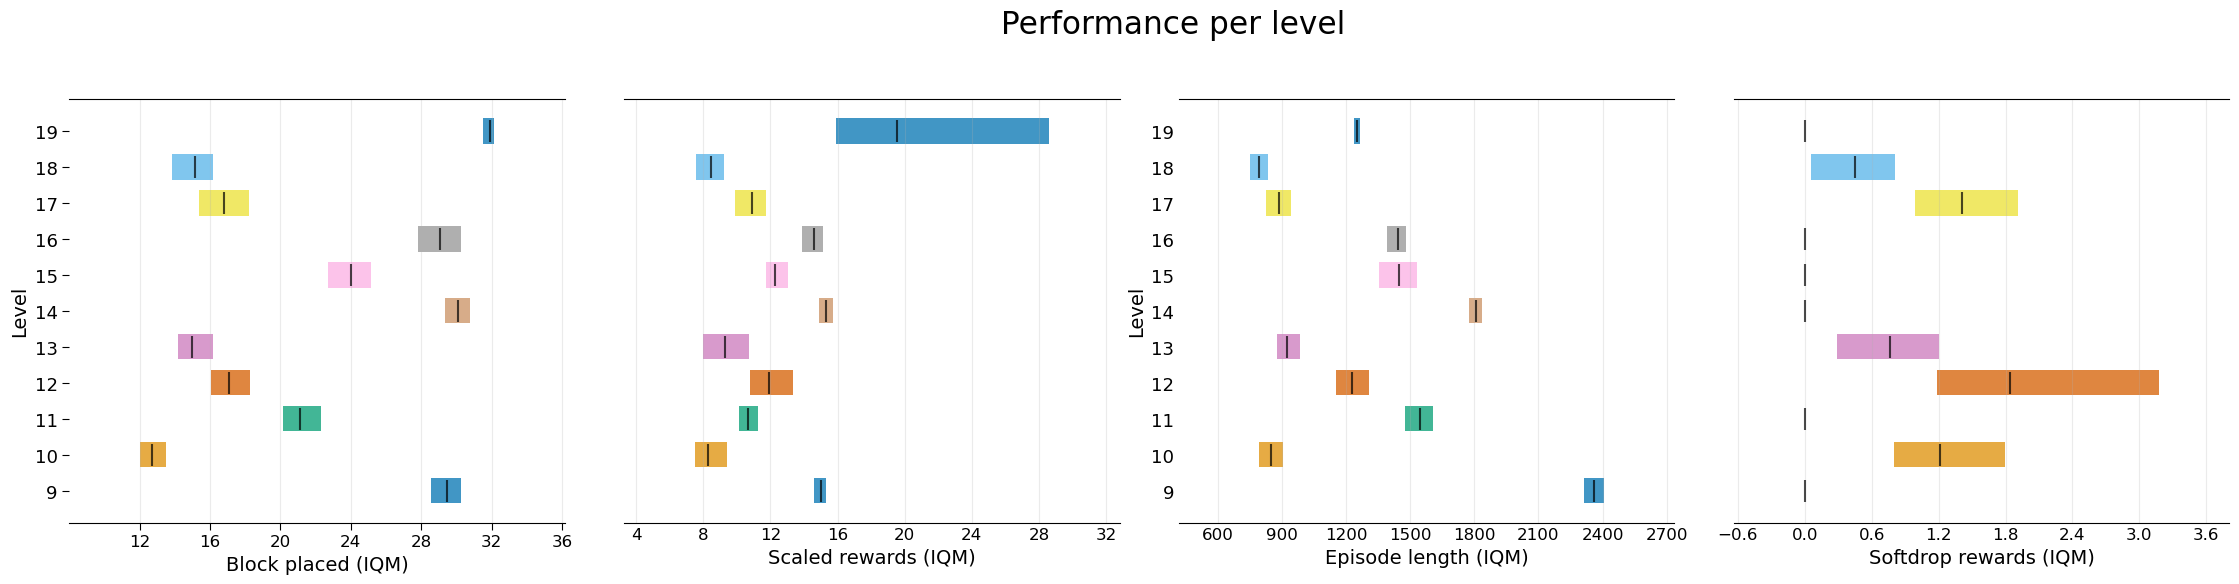

In [34]:
plot_interval(level_df_2nd, "Performance per level", level_df_2nd.parameter.unique(), level_df_2nd.level.unique())

(<Figure size 1800x400 with 3 Axes>,
 array([<Axes: xlabel='Block placed (IQM)', ylabel='Level'>,
        <Axes: xlabel='Scaled rewards (IQM)'>,
        <Axes: xlabel='Episode length (IQM)', ylabel='Level'>],
       dtype=object))

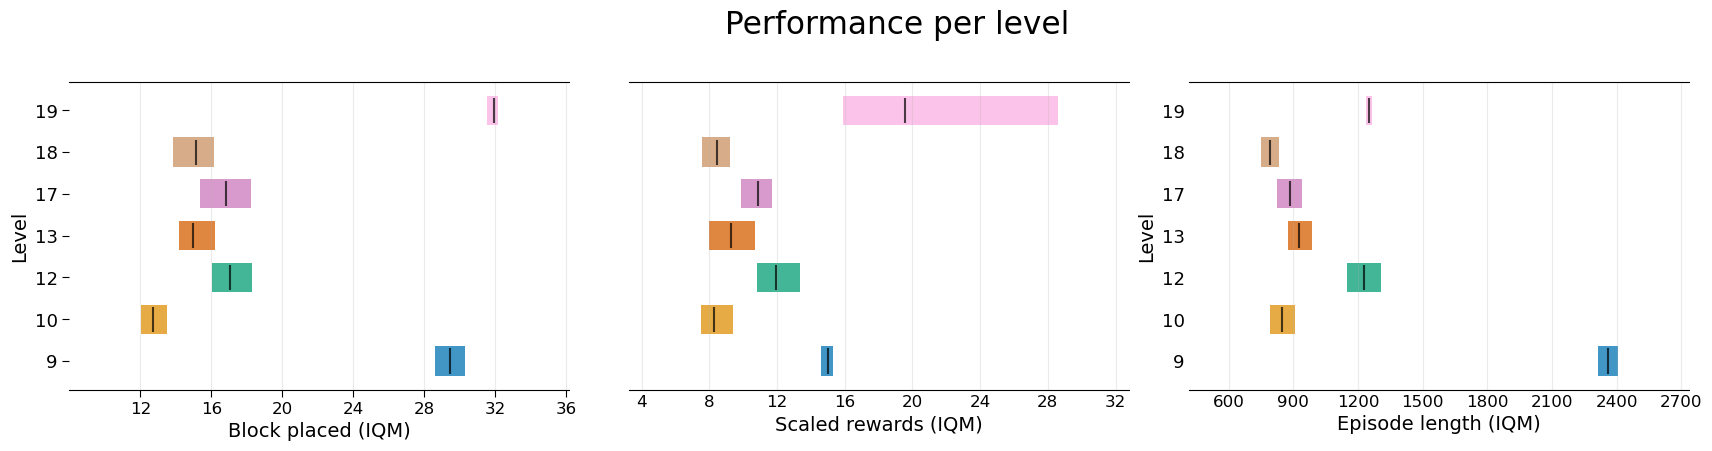

In [60]:
comparison_data = level_df_2nd[level_df_2nd["level"].isin([19, 18, 17, 13, 12, 10, 9])]
plot_interval(comparison_data, "Performance per level", comparison_data.parameter.unique()[:3], comparison_data.level.unique())

In [434]:
level_df.set_index("parameter")

,lower_bound,upper_bound,mean,std,level
parameter,,,,,
block_placed,12.014085,13.491236,12.725246,0.423991,10
block_placed,20.137873,22.358238,21.145996,0.552761,11
block_placed,16.079304,18.320787,17.083701,0.595540,12
block_placed,14.173876,16.215990,14.956565,0.529693,13
block_placed,29.365079,30.759346,30.072522,0.360326,14
block_placed,22.816488,25.152650,24.048809,0.626022,15
block_placed,27.796216,30.264706,29.081593,0.678063,16
block_placed,15.373128,18.152608,16.786686,0.767755,17
block_placed,13.833279,16.147071,15.143976,0.661399,18


In [433]:
level_df.set_index("parameter").to_csv("UNREAL-eval/generalize/CI.csv")

In [ ]:
width = []
CI = []
fig, axes = plt.subplots(2, 5, figsize=(25, 8))  # Membuat grid 2 baris dan 5 kolom
axes = axes.flatten()  # Membuat axes menjadi array 1D untuk akses mudah

for i in range(10):
    data_level = data[data["level"] == i+10]
    stats, lb, ub, mean, std = confidence_intervals(data_level, "episode_length", 2000)

    # Membuat histogram distribusi data
    sns.histplot(stats, bins=20, kde=True, ax=axes[i], edgecolor='black', alpha=0.7)

    # Membuat garis lower dan upper bound
    axes[i].axvline(lb, color='r', linestyle='dashed', linewidth=2, label=f'Lower Bound ({lb:.2f})')
    axes[i].axvline(ub, color='g', linestyle='dashed', linewidth=2, label=f'Upper Bound ({ub:.2f})')

    axes[i].text(0.05, 0.95, f'Mean: {mean:.2f}\nStd: {std:.2f}', 
                 transform=axes[i].transAxes, fontsize=8, va='top', bbox=dict(boxstyle="round", alpha=0.5, color="white"))

    # Menambahkan keterangan (legend)
    axes[i].legend(loc='upper right', fontsize=8)

    # Melabeli judul, sumbu-X, dan sumbu-Y
    axes[i].set_title(f'Level {i+10}')
    axes[i].set_xlabel('Mean (Relative reward)')
    axes[i].set_ylabel('Frequency')

    is_valid = validate_95_percent_ci(stats, lb, ub)
    print(f"Percentage: {is_valid * 100}%")
    width.append(ub-lb)
    CI.append([lb, ub])

max_idx = width.index(max(width))
min_idx = width.index(min(width))
print(f"Level dengan konsistensi tertinggi: {min_idx+10}, dengan lebar distribusi {width[min_idx]}")
print(f"Level yang paling tidak konsisten: {max_idx+10}, dengan lebar distribusi {width[max_idx]}", )

plt.tight_layout()  # Mengatur layout agar tidak overlap
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))  # You can adjust the size
ax = sns.heatmap(action_data, annot=True, fmt='d', linewidths=0.5, yticklabels=action_data.index, annot_kws={"size": 18})

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)  # Ukuran font ticks colorbar

# Add labels and title
plt.title('\nHeatmap aksi per Level\n', fontsize=18)
plt.xlabel('\nActions\n', fontsize=18)
plt.ylabel('Level', fontsize=18)

# Show the heatmap
plt.show()

In [73]:
summary_df = data.groupby("level").agg(
    avg_reward=("scaled_rewards", "mean"),
    avg_blocks=("block_placed", "mean"),
    avg_episode_length=("episode_length", "mean"),
    avg_lines=("lines", "mean"),
    avg_softdrop=("softdrop_rewards", "mean")
).reset_index()

In [ ]:
# Membuat lineplot untuk avg_scores, avg_blocks, dan avg_episode_length
plt.figure(figsize=(10, 6))

sns.lineplot(data=summary_df, x='level', y='avg_reward', marker='o', label='Scaled Rewards', linewidth=2, errorbar="ci")
sns.lineplot(data=summary_df, x='level', y='avg_blocks', marker='o', label='Block', linewidth=2, errorbar="ci")
sns.lineplot(data=summary_df, x='level', y='avg_softdrop', marker='o', label='Softdrop rewards', linewidth=2, errorbar="ci")
# sns.lineplot(data=summary_df, x='level', y='avg_lines', marker='o', label='Average Lines', linewidth=2, errorbar="ci")
# sns.lineplot(data=summary_df, x='level', y='avg_episode_length', marker='o', label='Average Episode Length', linewidth=2, errorbar="ci")

# Menambahkan label dan title
plt.title('Peingkatan kinerja per Level\n', fontsize=16)
plt.xticks(summary_df['level'])
plt.xlabel('Level', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)

# Menambahkan legend
plt.legend(title='Metrik')

# Menampilkan plot
plt.show()

In [ ]:
df_baseline = pd.read_csv("./UNREAL-eval/baseline/csv/different-seed/baseline.csv")
df_trained = pd.read_csv("./UNREAL-eval/baseline/csv/different-seed/trained.csv")

In [438]:
action_baselines_df = pd.DataFrame([
    np.sum([[seq.count(str(action)) for action in range(6)] for seq in df_baseline["action_taken"]], axis=0),
    np.sum([[seq.count(str(action)) for action in range(6)] for seq in df_trained["action_taken"]], axis=0),
], columns=[' '.join(item) for item in SIMPLE_MOVEMENT], index=["baseline", "trained"])

In [ ]:
action_baselines_df

In [ ]:
plt.figure(figsize=(12, 5))  # You can adjust the size
ax = sns.heatmap(action_baselines_df, annot=True, cmap="rocket", fmt='d', linewidths=0.5, yticklabels=action_baselines_df.index, annot_kws={"size": 18})

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)

# Add labels and title
plt.title('Perbandingan Heatmap aksi agen terlatih dengan agen random\n', fontsize=18)
plt.xlabel('\nActions', fontsize=18)
plt.ylabel('Level', fontsize=18)

# Show the heatmap
plt.show()

In [ ]:
pixels_df = pd.read_csv("./UNREAL-eval/pixel/pixels.csv")
pixels_df["probability"] = pixels_df["probability"].apply(ast.literal_eval)
pixels_df = pixels_df.drop(columns=["Unnamed: 0"])
pixels_df.head()

In [ ]:
probability_array = np.array(pixels_df['probability'].tolist())

# Membuat heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(probability_array, annot=True, cmap='YlGnBu', fmt='.2f', 
            xticklabels=[' '.join(item) for item in SIMPLE_MOVEMENT],
            yticklabels=pixels_df.index)

# Mengatur judul dan label
plt.title('\nProbabilitas Aksi pada setiap Level\n', fontsize=16)
plt.xlabel('\nAksi\n', fontsize=12)
plt.ylabel('Level', fontsize=12)

# Menampilkan plot
plt.tight_layout()
plt.show()

In [162]:
group = data.groupby('level')["board_history"].sum()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 5))
axes = axes.flatten()
plt.rcParams.update({
    'font.size': 11,          # Ukuran font default
    'axes.titlesize': 12,     # Ukuran font judul plot
    'axes.labelsize': 8,     # Ukuran font label sumbu
    'xtick.labelsize': 8,    # Ukuran font tick label sumbu x
    'ytick.labelsize': 8,    # Ukuran font tick label sumbu y
    'legend.fontsize': 0,    # Ukuran font legend
})
for i in range(10):
    sns.heatmap(group.iloc[i], ax=axes[i], cmap="magma")
    axes[i].set_title(f"Heatmap level {i + 10}", fontsize=10)

plt.tight_layout()
plt.plot()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Daftar level yang akan dibandingkan (misalnya level 10 vs level 19)
levels_to_compare = [i for i in range(10, 20)]
# Looping untuk membandingkan gambar Level 10 dengan gambar Level 19
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 12))
axes = axes.flatten()

for i, level in enumerate(levels_to_compare[:-1]):  # Ambil level 10 dan bandingkan dengan Level 19
    # Membaca gambar Level 10 dan Level 19
    image1 = cv2.imread(f'./UNREAL-eval/pixel/Level {level}.png', cv2.IMREAD_UNCHANGED)
    image2 = cv2.imread(f'./UNREAL-eval/pixel/Level {levels_to_compare[-1]}.png', cv2.IMREAD_UNCHANGED)
    
    # Menghitung selisih antara kedua gambar
    difference = cv2.absdiff(image1, image2)  # Menghitung perbedaan absolut antara dua gambar
    
    pixel_diff = np.sum(difference != 0)  # Hitung jumlah piksel yang berbeda
    
    # Plot perbandingan selisih antara Level yang dibandingkan dan Level 19
    axes[i].imshow(difference, cmap='gray')
    axes[i].set_title(f'Selisih piksel level {level} vs level {levels_to_compare[-1]}', fontsize=13)
    axes[i].set_xlabel(f"Diff: {pixel_diff} Pixel\n", fontsize=12)
    # Hide the ticks but keep the labels
    axes[i].set_yticks([])
    axes[i].set_xticks([])

for j in range(9, len(axes)):
    fig.delaxes(axes[j])  # Menghapus subplot yang tidak digunakan

plt.tight_layout()
plt.show()